In [1]:
!pip install transformers moviepy scikit-learn


In [2]:
from moviepy.editor import VideoFileClip
import os

# Function to extract frames
def extract_frames(video_path, frame_dir, fps=0.5):
    clip = VideoFileClip(video_path)
    os.makedirs(frame_dir, exist_ok=True)

    # Extract frames at regular intervals
    for i, frame in enumerate(clip.iter_frames(fps=fps)):
        frame_path = os.path.join(frame_dir, f"frame_{i:04d}.jpg")
        clip.save_frame(frame_path, t=i / fps)
    return sorted(os.listdir(frame_dir))






  if event.key is 'enter':



In [3]:
# Input video file path
video_path = "/content/BigBuckBunny_320x180.mp4"
frame_dir = "/content/frames"
frames = extract_frames(video_path, frame_dir)

In [4]:
print(f"Extracted {len(frames)} frames.")

Extracted 299 frames.


In [5]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import torch

# Load ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224").cuda()



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

  warnings.warn(



config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Function to process frames and extract features
def extract_features(frames, model, feature_extractor, frame_dir):
    frame_features = []
    for frame_path in frames:
        image_path = os.path.join(frame_dir, frame_path)
        image = Image.open(image_path).convert("RGB")
        inputs = feature_extractor(images=image, return_tensors="pt").to("cuda")
        with torch.no_grad():
            features = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
        frame_features.append(features[0])  # Flatten the feature array
    return frame_features

In [7]:
# Extract features for frames
features = extract_features(frames, model, feature_extractor, frame_dir)
print(f"Extracted features for {len(features)} frames.")

Extracted features for 299 frames.


In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Cluster frames into chapters
def cluster_frames(features, n_chapters=5):
    kmeans = KMeans(n_clusters=n_chapters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

# Perform clustering
n_chapters = 4 # Define the number of chapters
labels = cluster_frames(np.array(features), n_chapters=n_chapters)

# Associate each frame with its chapter
frame_chapters = {frames[i]: labels[i] for i in range(len(frames))}
print("Frame chapters:", frame_chapters)


Frame chapters: {'frame_0000.jpg': 1, 'frame_0001.jpg': 0, 'frame_0002.jpg': 0, 'frame_0003.jpg': 0, 'frame_0004.jpg': 0, 'frame_0005.jpg': 0, 'frame_0006.jpg': 0, 'frame_0007.jpg': 2, 'frame_0008.jpg': 3, 'frame_0009.jpg': 3, 'frame_0010.jpg': 3, 'frame_0011.jpg': 3, 'frame_0012.jpg': 2, 'frame_0013.jpg': 2, 'frame_0014.jpg': 2, 'frame_0015.jpg': 2, 'frame_0016.jpg': 2, 'frame_0017.jpg': 2, 'frame_0018.jpg': 2, 'frame_0019.jpg': 2, 'frame_0020.jpg': 2, 'frame_0021.jpg': 2, 'frame_0022.jpg': 2, 'frame_0023.jpg': 2, 'frame_0024.jpg': 2, 'frame_0025.jpg': 2, 'frame_0026.jpg': 2, 'frame_0027.jpg': 2, 'frame_0028.jpg': 2, 'frame_0029.jpg': 3, 'frame_0030.jpg': 3, 'frame_0031.jpg': 3, 'frame_0032.jpg': 3, 'frame_0033.jpg': 3, 'frame_0034.jpg': 3, 'frame_0035.jpg': 0, 'frame_0036.jpg': 3, 'frame_0037.jpg': 0, 'frame_0038.jpg': 3, 'frame_0039.jpg': 0, 'frame_0040.jpg': 0, 'frame_0041.jpg': 0, 'frame_0042.jpg': 0, 'frame_0043.jpg': 0, 'frame_0044.jpg': 0, 'frame_0045.jpg': 3, 'frame_0046.jpg':

In [9]:
# Summarize each chapter
def summarize_chapters(frame_chapters):
    chapters = {}
    for frame, chapter_id in frame_chapters.items():
        if chapter_id not in chapters:
            chapters[chapter_id] = []
        chapters[chapter_id].append(frame)
    return chapters

# Group frames into chapters
chapters = summarize_chapters(frame_chapters)
for chapter_id, frames in chapters.items():
    print(f"Chapter {chapter_id}: {len(frames)} frames")


Chapter 1: 48 frames
Chapter 0: 74 frames
Chapter 2: 59 frames
Chapter 3: 118 frames


In [10]:
import matplotlib.pyplot as plt

# Save representative frames for each chapter
def save_representative_frames(chapters, frame_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for chapter_id, frames in chapters.items():
        rep_frame_path = os.path.join(frame_dir, frames[len(frames)//2])  # Middle frame
        rep_frame = Image.open(rep_frame_path)
        rep_frame.save(os.path.join(output_dir, f"chapter_{chapter_id}.jpg"))

# Save representative frames
output_dir = "/content/chapters"
save_representative_frames(chapters, frame_dir, output_dir)




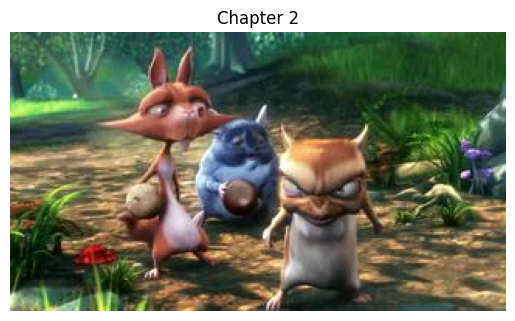

In [11]:

sample_chapter = 2
rep_frame_path = os.path.join(output_dir, f"chapter_{sample_chapter}.jpg")
image = Image.open(rep_frame_path)
plt.imshow(image)
plt.title(f"Chapter {sample_chapter}")
plt.axis("off")
plt.show()

In [12]:
!pip install sentence-transformers


In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load a text embedding model
text_model = SentenceTransformer('all-MiniLM-L6-v2')

# Example feature vectors for chapters
# These would be extracted from ViT during the earlier steps
chapter_features = np.random.rand(4, 384)  # Replace with actual chapter features

# Embed the query
query = "bunny "
query_vector = text_model.encode(query)

# Compute similarity between the query and chapter features
similarities = cosine_similarity([query_vector], chapter_features)
ranked_chapters = np.argsort(-similarities[0])  # Rank chapters by similarity

# Display results
print("Recommended Chapters:")
for idx in ranked_chapters[:2]:  # Top 2 chapters
    print(f"Chapter {idx}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Recommended Chapters:
Chapter 1
Chapter 3


In [14]:
# Chapter Metadata for Big Buck Bunny
chapter_metadata = {
    "chapter_0": {"genre": "Comedy", "mood": "Playful", "key_objects": ["Butterflies", "Flowers"], "key_characters": ["Bunny"]},
    "chapter_1": {"genre": "Action", "mood": "Chaotic", "key_objects": ["Fruit", "Sticks"], "key_characters": ["Bunny", "Rodents"]},
    "chapter_2": {"genre": "Drama", "mood": "Sad", "key_objects": ["Broken Trees", "Tears"], "key_characters": ["Bunny"]},
    "chapter_3": {"genre": "Revenge", "mood": "Exciting", "key_objects": ["Traps", "Fruit"], "key_characters": ["Bunny", "Rodents"]},
}


In [15]:
# Query Matching Function
def recommend_chapters_by_query(query, chapter_metadata):
    recommendations = []
    query = query.lower()

    for chapter, metadata in chapter_metadata.items():
        score = 0
        for key, values in metadata.items():
            # Match query with metadata values
            if isinstance(values, list):  # If metadata is a list
                score += sum(1 for value in values if query in value.lower())
            elif isinstance(values, str):  # If metadata is a string
                if query in values.lower():
                    score += 1
        if score > 0:
            recommendations.append((chapter, score))

    # Sort recommendations by relevance score
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations
